<a href="https://colab.research.google.com/github/ucestth/CECG0004_CHAOS/blob/Siwei/LeNet_reproduction_Chaos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras
In this notebook we compare the performance of two CNN architectures on the MNIST dataset. The first only uses the topology of the LeNet-5 network (the same number and types of layers, same kernel size and strides etc). The second is configured to as much details from the original paper as possible (Custom activation function, scheduled learning rate, custom network initialization), to faithfully reproduce the original LeNet-5 network from LeCun's 1998 paper.

To build our model we need to do a few steps:
- Download the MNIST dataset with consist of labeled handwritten images (28x28 px).
- Identify the feature that we are going to train the model on, which are just our image pixels.
- And let us use neural networks to build our model (LeNet-5 network architecture).
- The final step would to train our model and then test and validate how well we did.


## ***1. Download MNIST dataset***


Four files are available on this site, http://yann.lecun.com/exdb/mnist/:

* train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
* train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
* t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
* t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

In [118]:
from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

In [119]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

## Load the data

Load train and test data in memory

In [120]:
# Update libraries
!pip install seaborn==0.9.0

In [121]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [122]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)

    return features, labels

In [123]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

### Explore the data

It is always a good to do some data exploration before we start using it, find outliers, and decide if we need a preprocessing phase to uniform or augment it. And also to make sure that all the classes are covered by or more or less the same number of samples.


In [124]:
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# of training images: 60000
# of test images: 10000


#### Display some images

In [125]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

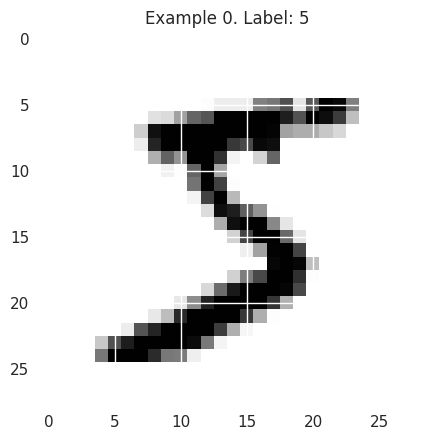

In [126]:
display_image(0)

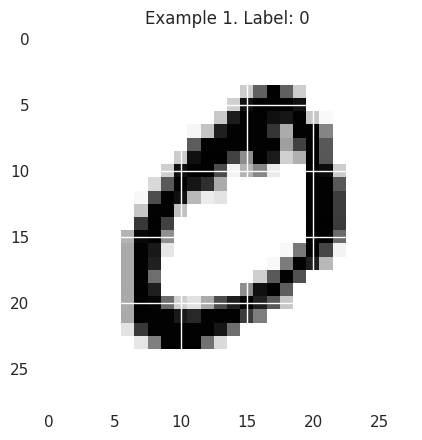

In [127]:
display_image(1)

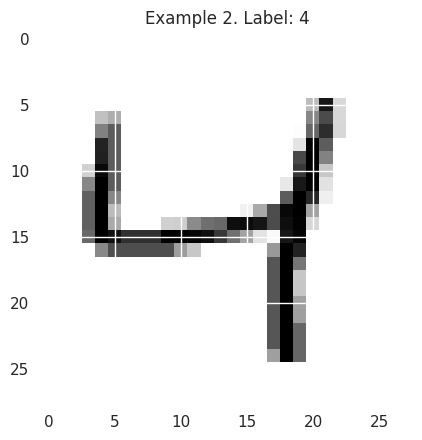

In [128]:
display_image(2)

#### Plot training data

In [129]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


### Split training data into training and validation

In [130]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [131]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


## ***2. Prepare our input features***

The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [132]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')

print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


## ***3. A vanilla CNN implmentation (only using LeNet-5's topology, no detailed implementations)***

![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
>>> LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)


#### Input
    32x32x1 pixels image

#### A CNN Architecture configured according to LeNet-5's topology, but not using any specifics from the original paper such as custom activation function
* **Convolutional #1** outputs 28x28x6
    * **Activation** any activation function, we will `relu`

* **Pooling #1** The output shape should be 14x14x6.

* **Convolutional #2** outputs 10x10x16.
    * **Activation** any activation function, we will `relu`

* **Pooling #2** outputs 5x5x16.
    * **Flatten** Flatten the output shape of the final pooling layer

* **Fully Connected #1** outputs 120
    * **Activation** any activation function, we will `relu`

* **Fully Connected #2** outputs 84
    * **Activation** any activation function, we will `relu`

* **Fully Connected (Logits) #3** outpute 10


## 3A. Model Architecture

In [133]:
EPOCHS = 10
BATCH_SIZE = 128

In [134]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [135]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [136]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [137]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_6 (Avera  (None, 15, 15, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_7 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_3 (Flatten)         (None, 576)               0         
                                                                 
 dense_9 (Dense)             (None, 120)              

##3B. Training

In [138]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[tensorboard])

# of training images: 48000
# of validation images: 12000
Epoch 1/10


<ipython-input-138-319f01e6f6d5>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,


375/375 [==============================] - 8s 15ms/step - loss: 0.3468 - accuracy: 0.9150 - val_loss: 0.0948 - val_accuracy: 0.9704
Epoch 2/10
375/375 [==============================] - 7s 17ms/step - loss: 0.0760 - accuracy: 0.9767 - val_loss: 0.0749 - val_accuracy: 0.9761
Epoch 3/10
375/375 [==============================] - 6s 15ms/step - loss: 0.0506 - accuracy: 0.9839 - val_loss: 0.0492 - val_accuracy: 0.9848
Epoch 4/10
375/375 [==============================] - 6s 15ms/step - loss: 0.0404 - accuracy: 0.9873 - val_loss: 0.0509 - val_accuracy: 0.9856
Epoch 5/10
375/375 [==============================] - 5s 13ms/step - loss: 0.0335 - accuracy: 0.9891 - val_loss: 0.0433 - val_accuracy: 0.9863
Epoch 6/10
375/375 [==============================] - 5s 13ms/step - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.0447 - val_accuracy: 0.9866
Epoch 7/10
375/375 [==============================] - 5s 13ms/step - loss: 0.0205 - accuracy: 0.9933 - val_loss: 0.0439 - val_accuracy: 0.9865
Epoch 8/10

## 3C. Model Performance & Evaluation

In [139]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0640 - accuracy: 0.9816
Test loss: 0.06397411227226257
Test accuracy: 0.9815999865531921


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


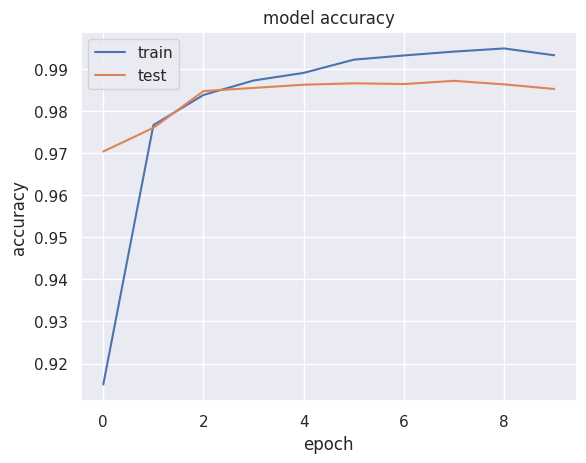

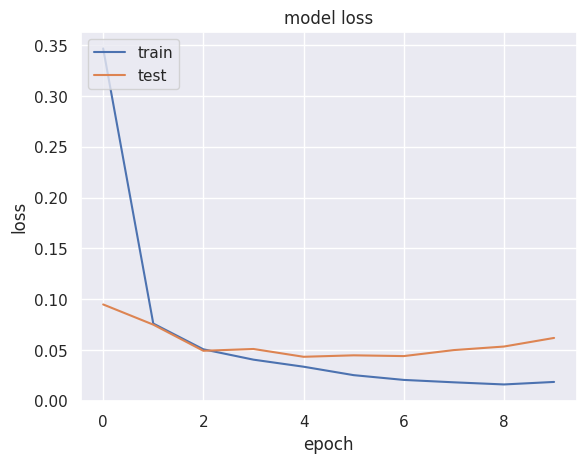

In [140]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [141]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

LOG_DIR = 'logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

--2024-02-17 19:48:28--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.28M  38.7MB/s    in 0.3s    

2024-02-17 19:48:29 (38.7 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


313/313 [==============================] - 1s 3ms/step


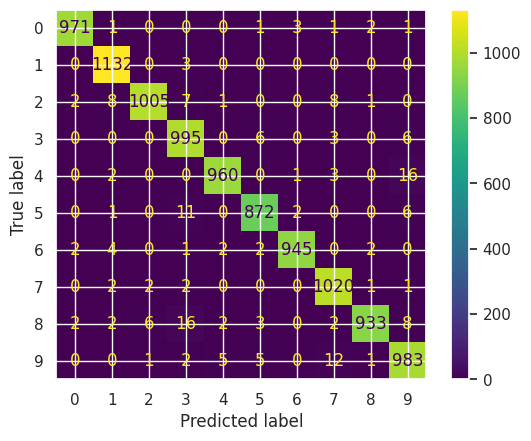

In [142]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
mat = model.predict(test['features'])
y_pred = np.argmax(mat,axis=1)
conf_mat = confusion_matrix(test['labels'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()

plt.show()

In [143]:
precision = precision_score(test['labels'],y_pred, average = 'micro')
recall= recall_score(test['labels'],y_pred, average = 'micro')
f1 = f1_score(test['labels'],y_pred, average = 'micro')

print('Precision =', precision, 'Recall = ',recall, 'F1-score =',f1)

Precision = 0.9816 Recall =  0.9816 F1-score = 0.9816


## ***4. LeNet-5 implementation (with detailed implementations, as close to the original LeNet-5 as possible)***
![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
>>> LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)

#### LeNet-5 Architecture fully configured according to the original paper
* **Convolutional #1** outputs 28x28x6
    * **Activation** Custom tanh

* **Pooling #1** The output shape should be 14x14x6.

* **Convolutional #2** outputs 10x10x16.
    * **Activation** Custom tanh

* **Pooling #2** outputs 5x5x16.
    * **Flatten** Flatten the output shape of the final pooling layer

* **Fully Connected #1** outputs 120
    * **Activation** Custom tanh

* **Fully Connected #2** outputs 84
    * **Activation** Custom tanh

* **Fully Connected (Logits) #3** output 10


### 4A Custom activation  function



In [144]:
from keras.layers import Activation
from keras import backend as K
from keras.utils import get_custom_objects

## In the original LeNet-5 model a customised version of a hyperbolic tangent activation function was used
## Please refer to LeCun's paper on page 8 under section B and Appendix A for more details.
## The following function defined activation function according to the original paper

'''
Custom activation function:
    f(a) = A*tanh(S*a)
    where A = 1.1759 and S = 2/3
'''

def custom_activation(x):
    return (K.tanh(2/3 * x) * 1.7159)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})


### 4B Learning rate scheduler

In [145]:
from keras.callbacks import LearningRateScheduler

## In the original LeNet-5 model The global learning rate was scheduled instead of being fixed throughout all the training epochs.
## Please refer to LeCun's original paper on page 10 under section IIIB for more details.
## The following function defined allows us to schedule the learning rates according to the original paper

'''
 Global learning rate was scheduled as:
        0.0005 for the first two passes;
        0.0002 for the next three;
        0.0001 for the next three;
        0.000 05 for the next 4;
        and 0.000 01 thereafter.
        20 training epochs in total.
'''

def lr_schedule(epoch, lr):
    if epoch < 2:
        return 0.0005
    elif epoch < 5:
        return 0.0002
    elif epoch < 8:
        return 0.0001
    elif epoch < 12:
        return 0.00005
    else:
        return 0.00001

callback = LearningRateScheduler(lr_schedule)


### 4C LeNet-5 model architecture

In [146]:
model_1 = keras.Sequential()

model_1.add(layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1,1), activation=custom_activation, input_shape=(32,32,1), padding='valid'))
model_1.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

model_1.add(layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1,1), activation=custom_activation, input_shape=(32,32,1), padding='valid'))
model_1.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

model_1.add(layers.Flatten())

model_1.add(layers.Dense(units=120, activation=custom_activation))

model_1.add(layers.Dense(units=84,activation=custom_activation))

model_1.add(layers.Dense(units=10, activation = 'softmax'))

model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


In [147]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_8 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_9 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_4 (Flatten)         (None, 400)               0         
                                                                 
 dense_12 (Dense)            (None, 120)              

##4D. Training

In [148]:
EPOCHS_1 = 20 ## 20 training epochs
BATCH_SIZE_1 = 128 ## batch size is 128

In [149]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch_1 = X_train.shape[0]//BATCH_SIZE_1
validation_steps_1 = X_validation.shape[0]//BATCH_SIZE_1

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history_1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch_1, epochs=EPOCHS_1,
                    validation_data=validation_generator, validation_steps=validation_steps_1,
                    shuffle=True, callbacks=[callback])

# of training images: 48000
# of validation images: 12000
Epoch 1/20


<ipython-input-149-f885cbd94560>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch_1, epochs=EPOCHS_1,


375/375 [==============================] - 8s 13ms/step - loss: 0.2801 - accuracy: 0.9196 - val_loss: 0.1036 - val_accuracy: 0.9686 - lr: 5.0000e-04
Epoch 2/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0912 - accuracy: 0.9726 - val_loss: 0.0701 - val_accuracy: 0.9782 - lr: 5.0000e-04
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0624 - accuracy: 0.9815 - val_loss: 0.0563 - val_accuracy: 0.9831 - lr: 2.0000e-04
Epoch 4/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0544 - accuracy: 0.9839 - val_loss: 0.0539 - val_accuracy: 0.9829 - lr: 2.0000e-04
Epoch 5/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0487 - accuracy: 0.9850 - val_loss: 0.0475 - val_accuracy: 0.9855 - lr: 2.0000e-04
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0418 - accuracy: 0.9879 - val_loss: 0.0466 - val_accuracy: 0.9853 - lr: 1.0000e-04
Epoch 7/20
375/375 [==============================] - 3s

##4E. Model Performance & Evaluation

In [150]:
score = model_1.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0359 - accuracy: 0.9881
Test loss: 0.03591148927807808
Test accuracy: 0.988099992275238


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


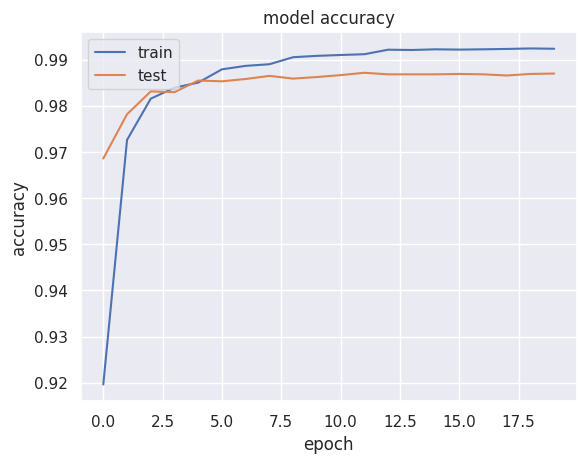

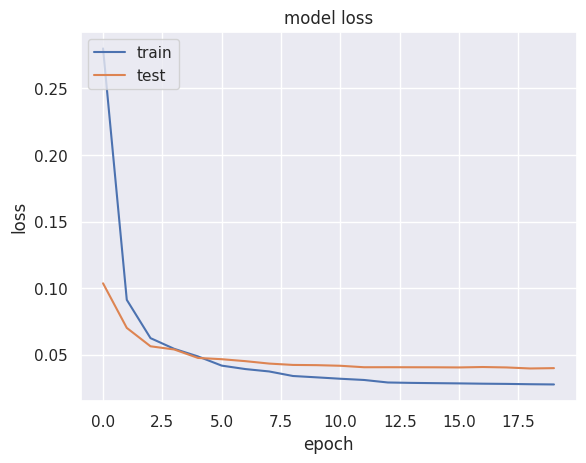

In [151]:
import matplotlib.pyplot as plt
# list all data in history

print(history_1.history.keys())
# summarize history for accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



313/313 [==============================] - 1s 2ms/step


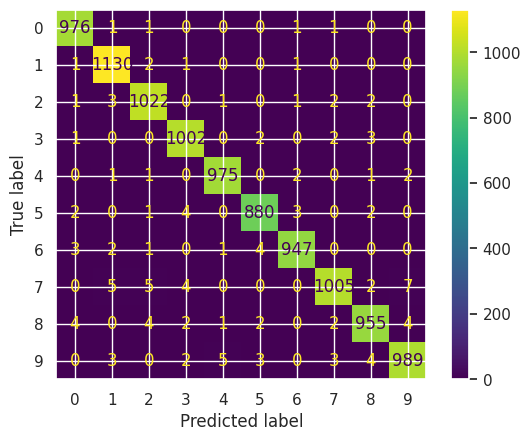

In [152]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
mat1 = model_1.predict(test['features'])
y_pred1 = np.argmax(mat1,axis=1)
conf_mat1 = confusion_matrix(test['labels'], y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat1)
disp.plot()


plt.show()

In [153]:
precision1 = precision_score(test['labels'],y_pred1, average = 'micro')
recall1= recall_score(test['labels'],y_pred1, average = 'micro')
f11 = f1_score(test['labels'],y_pred1, average = 'micro')

print('Precision =', precision1, 'Recall = ',recall1, 'F1-score =',f11)

Precision = 0.9881 Recall =  0.9881 F1-score = 0.9881


# ***5. Performance Comparison: Vanilla CNN vs LeNet-5***

### 5A. Accuracy and Loss during training

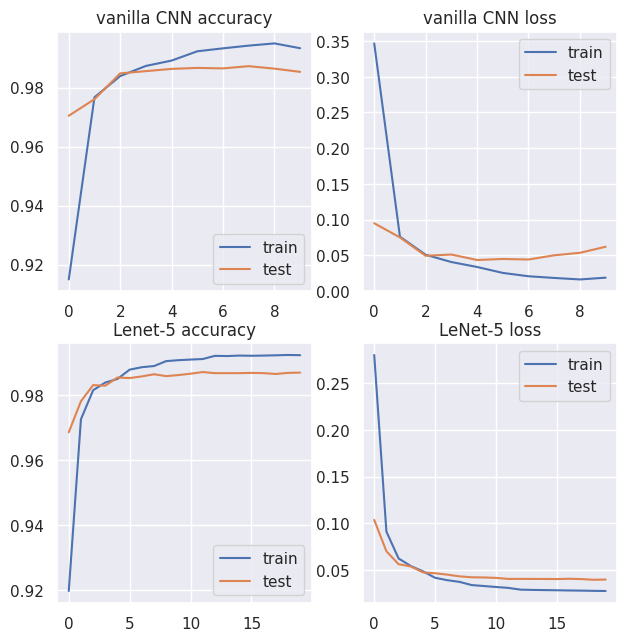

In [154]:
figure, axis = plt.subplots(2, 2)

axis[0, 0].plot(history.history['accuracy'])
axis[0, 0].plot(history.history['val_accuracy'])
axis[0, 0].legend(['train', 'test'], loc='lower right')
axis[0, 0].set_title("vanilla CNN accuracy")

axis[0, 1].plot(history.history['loss'])
axis[0, 1].plot(history.history['val_loss'])
axis[0, 1].legend(['train', 'test'], loc='upper right')
axis[0, 1].set_title("vanilla CNN loss")

axis[1, 0].plot(history_1.history['accuracy'])
axis[1, 0].plot(history_1.history['val_accuracy'])
axis[1, 0].legend(['train', 'test'], loc='lower right')
axis[1, 0].set_title("Lenet-5 accuracy")

axis[1, 1].plot(history_1.history['loss'])
axis[1, 1].plot(history_1.history['val_loss'])
axis[1, 1].legend(['train', 'test'], loc='upper right')
axis[1, 1].set_title("LeNet-5 loss")

plt.subplots_adjust(bottom=0.01, right=1, top=1.2)

# Combine all the operations and display
plt.show()

## 5B. Confusion Matrix

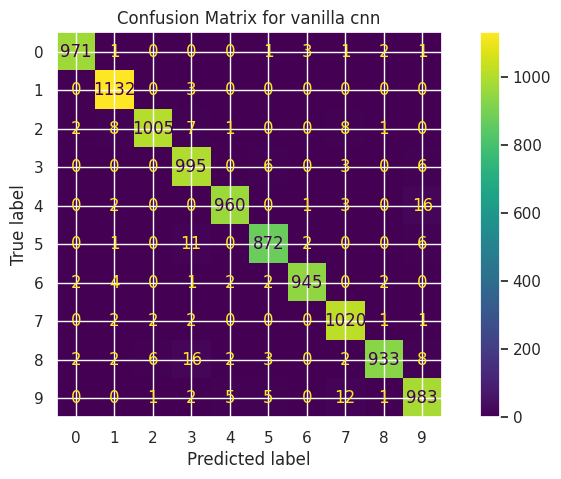

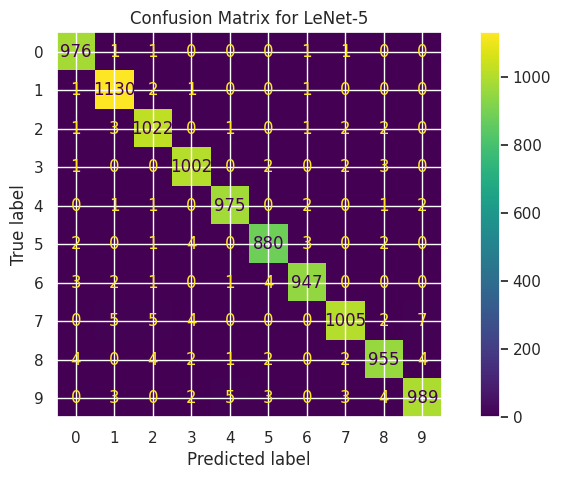

In [155]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, accuracy_score, ConfusionMatrixDisplay


fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(test['labels'], y_pred, ax=ax)

_ = ax.set_title(
    f"Confusion Matrix for vanilla cnn"
)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(test['labels'], y_pred1, ax=ax)

_ = ax.set_title(
    f"Confusion Matrix for LeNet-5"
)


plt.show()

### 5C. Precision, Recall, F1 and F2 scores

In [156]:

precision = precision_score(test['labels'],y_pred, average = 'micro')
recall= recall_score(test['labels'],y_pred, average = 'micro')
f1 = f1_score(test['labels'],y_pred, average = 'micro')
f2 = fbeta_score(test['labels'], y_pred, average='micro', beta=0.5)


print('Vanilla CNN Precision =', precision, 'Recall = ',recall, 'F1-score =',f1, 'F2-score =',f2)

precision1 = precision_score(test['labels'],y_pred1, average = 'micro')
recall1= recall_score(test['labels'],y_pred1, average = 'micro')
f11 = f1_score(test['labels'],y_pred1, average = 'micro')
f22 = fbeta_score(test['labels'], y_pred1, average='micro', beta=0.5)


print('LeNet-5 Precision =', precision1, 'Recall = ',recall1, 'F1-score =',f11, 'F2-score =',f22)

Vanilla CNN Precision = 0.9816 Recall =  0.9816 F1-score = 0.9816 F2-score = 0.9816
LeNet-5 Precision = 0.9881 Recall =  0.9881 F1-score = 0.9881 F2-score = 0.9881000000000001
